In [4]:
import eegPinelineDesign
import numpy as np
import random
import mne
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot') 
import os
import pandas as pd
import re
import json
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA,FastICA
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from scipy.fftpack import fft,ifft
import math
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from scipy.signal import spectrogram,find_peaks_cwt
from mne.preprocessing.ica import ICA
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.cross_validation import train_test_split,ShuffleSplit
from sklearn.preprocessing import label_binarize,scale
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize,StandardScaler
from nitime import algorithms as alg


In [5]:
eegPinelineDesign.change_file_directory('C:/Users/ning/Downloads/training set')
EDFfiles, Annotationfiles = eegPinelineDesign.split_type_of_files()

['64chlocs.elp', 'label_extraction.npy', 'label_extraction.pkl', 's5d2_final.edf', 's5d2_final_annotations.txt', 's6n2_final.edf', 's6n2_final_annotations.txt', 'Sleep Stage Scoring Criteria.docx', 'suj10_d1final.edf', 'suj10_d1final_annotations.txt', 'suj10_d2final.edf', 'suj10_d2final_annotations.txt', 'suj13_l2nap_day2 edited.edf', 'suj13_l2nap_day2 edited1.edf', 'suj13_l2nap_day2 edited1_annotations.txt', 'suj13_l2nap_day2 edited_annotations.txt', 'suj13_l2nap_day2 edited_C3.txt', 'suj13_l2nap_day2 edited_C4.txt', 'suj13_l2nap_day2 edited_F3.txt', 'suj13_l2nap_day2 edited_F4.txt', 'suj13_l2nap_day2 edited_O1.txt', 'suj13_l2nap_day2 edited_O2.txt', 'suj5_d1final.edf', 'suj5_d1final_annotations.txt', 'suj6_d1final.edf', 'suj6_d1final_annotations.txt', 'suj8_d1final.edf', 'suj8_d1final_annotations.txt', 'suj8_d2final.edf', 'suj8_d2final_annotations.txt', 'suj9_d1final.edf', 'suj9_d1final_annotations.txt', 'suj9_d2final.edf', 'suj9_d2final_annotations.txt', 'testing-montage-2.mtg', 'Tr

Extracting edf Parameters from s5d2_final.edf...
Setting channel info structure...
Creating Raw.info structure...
Reading 0 ... 3383999  =      0.000 ...  3383.999 secs...
[done]
Ready.
Fitting ICA to data using 8 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
Using all PCA components: 8
    Searching for artifacts...
    found 2 artifacts by EOG 00
    found 1 artifact by skewness
    found 1 artifact by kurtosis
    found 1 artifact by variance
Artifact indices found:
    5, 6, 0, 0, 7
    Removing duplicate indices...
Ready.
Transforming to ICA space (8 components)
Zeroing out 4 ICA components
Inverse transforming to PCA space
Reconstructing sensor space signals from 8 PCA components
Low-pass filtering at 5e+02 Hz
Low-pass filtering at 1e+02 Hz
Extracting edf Parameters from s6n2_final.edf...
Setting channel info structure...
Creating Raw.info structure...
Reading 0 ... 2073999  =      0.000 ...  2073.999 secs...
[done]
Ready.
Fitting 

C:\Anaconda3\lib\site-packages\mne\filter.py:333: UserWarning: Attenuation at stop frequency 7.5Hz is only 18.1dB.
  '%0.1fdB.' % (att_freq, att_db))
C:\Anaconda3\lib\site-packages\mne\filter.py:333: UserWarning: Attenuation at stop frequency 17.0Hz is only 17.9dB.
  '%0.1fdB.' % (att_freq, att_db))
C:\Anaconda3\lib\site-packages\mne\filter.py:333: UserWarning: Attenuation at stop frequency 29.5Hz is only 17.9dB.
  '%0.1fdB.' % (att_freq, att_db))


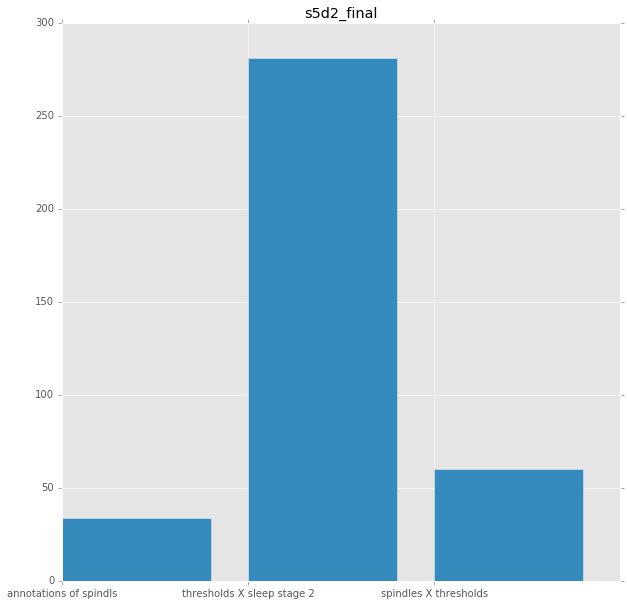

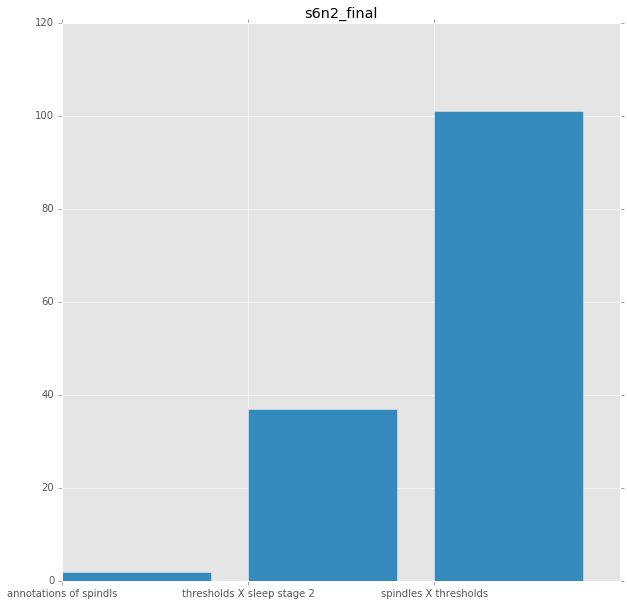

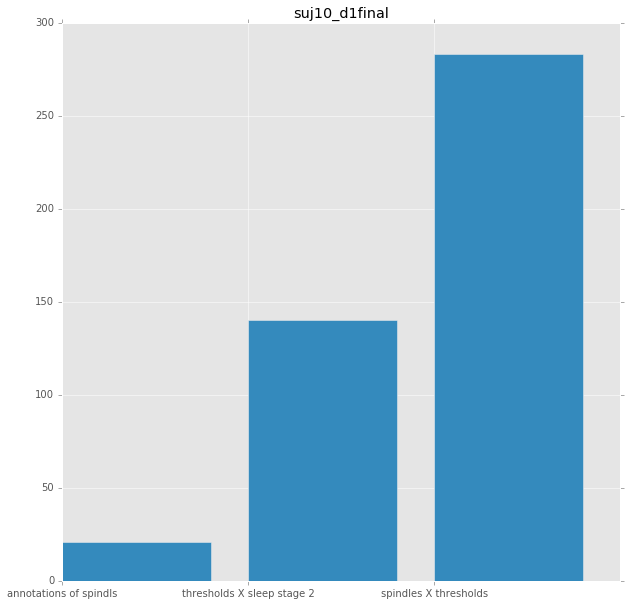

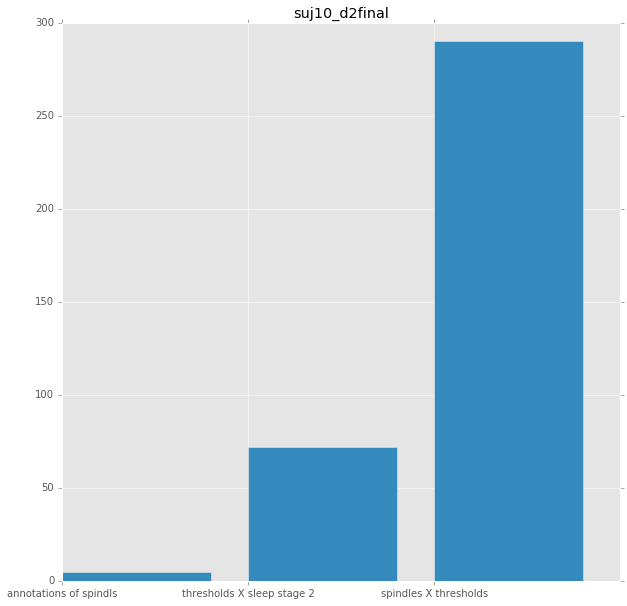

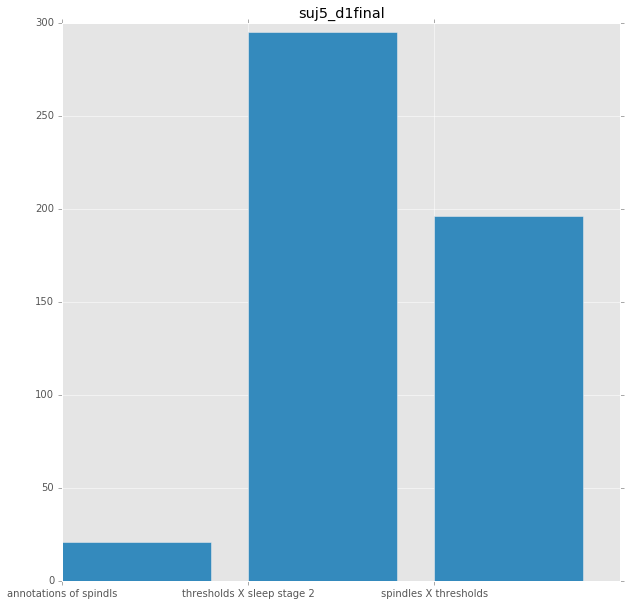

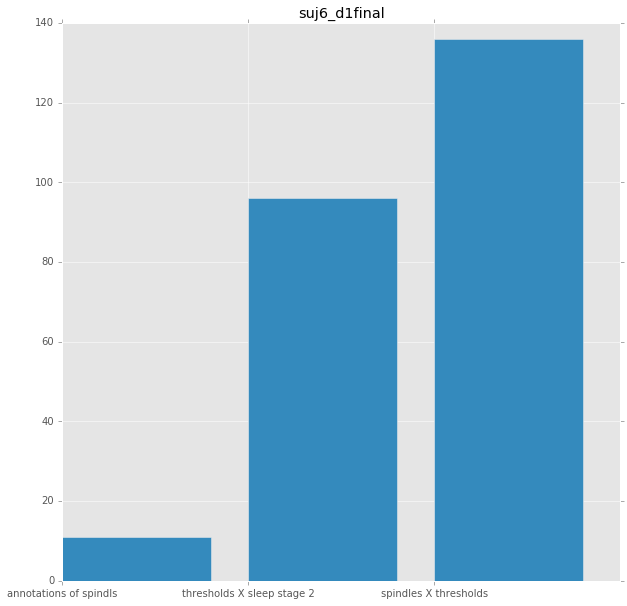

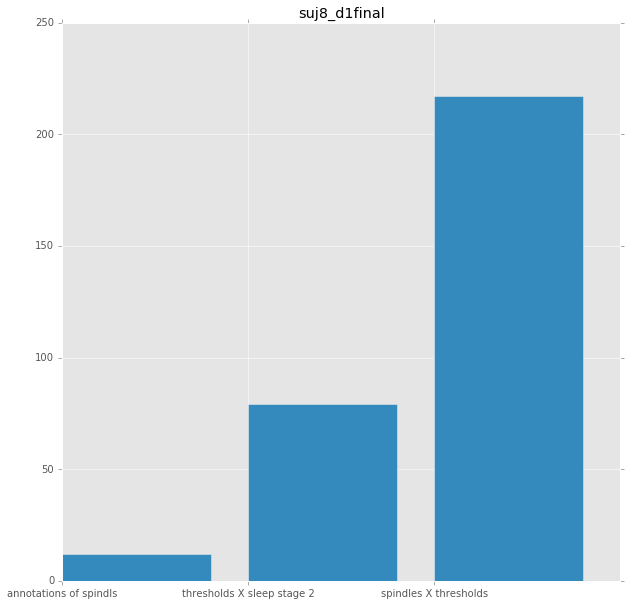

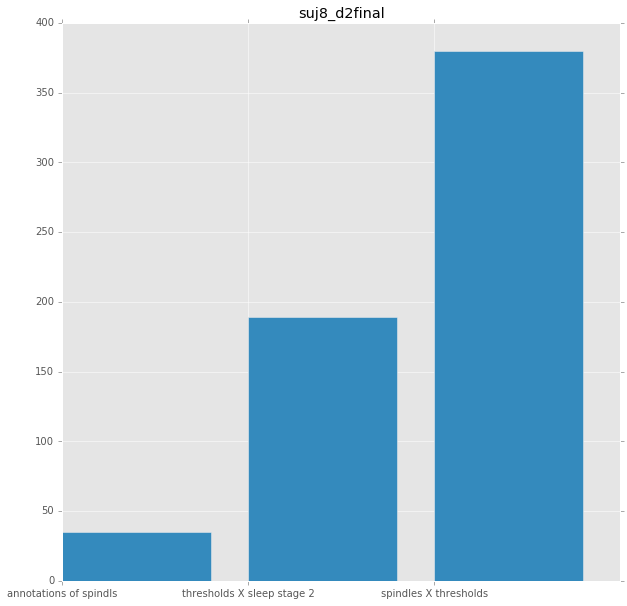

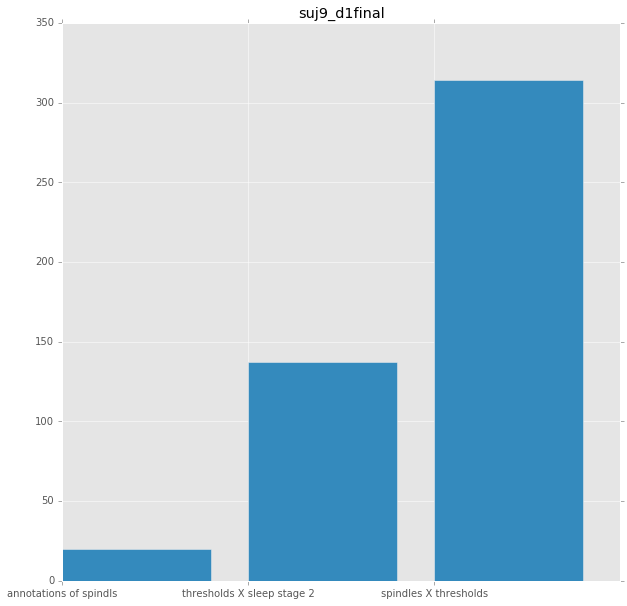

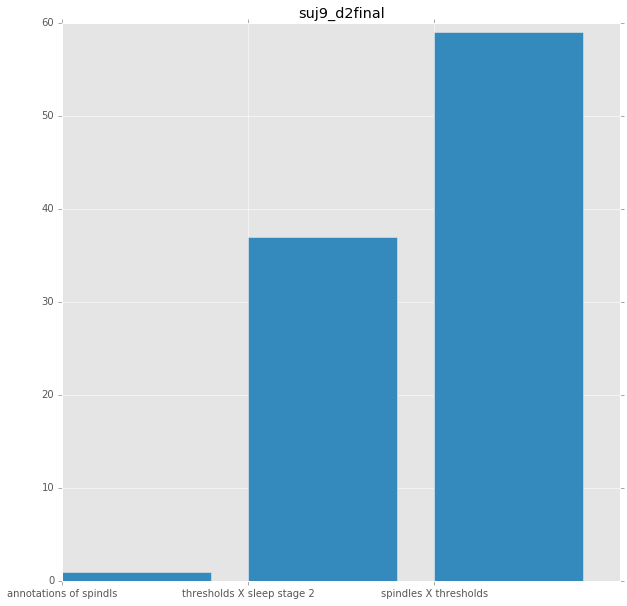

In [6]:
resolution = 1;result = {}

# whether two intervals overlap
def getOverlap(a,b):
    return max(0,min(a[1],b[1]) - max(a[0],b[0]))


for num, item in enumerate(EDFfiles):
    if item == 'suj13_l2nap_day2 edited.edf' or item =='suj13_l2nap_day2 edited1.edf':
        pass
    else:
        file_to_read,fileName=eegPinelineDesign.pick_sample_file(EDFfiles,n=num)
        # channel list for artifact(eyemovement or chewing) removal - ROC and/or LOC
        channelList = ['F3','F4','C3','C4','O1','O2','ROC','LOC']
        raw = eegPinelineDesign.load_data(file_to_read,channelList,None, 100)# low pass
        annotation_to_read = [x for x in Annotationfiles if fileName in x]
        file = pd.read_csv(annotation_to_read[0])
        labelFind = re.compile('spindle',eegPinelineDesign.re.IGNORECASE)
        spindles=[]# take existed annotations
        for row in file.iterrows():
            currentEvent = row[1][-1]
            if labelFind.search(currentEvent):
                spindles.append(row[1][0])
                
        # threshold test to detect possible spindle segments
        ratio_index =[];muscle_index=[];sample_ind=[];channelList=['F3','F4','C3','C4','O1','O2']
        
        #initialize
        windowsize=5;endPoint=windowsize;startPoint=endPoint-windowsize
        distance_to_end = raw.last_samp/1000 - endPoint
        
        # start the while loop
        while distance_to_end > windowsize:
            for ii, names in enumerate(channelList):
                # add all the channels together
                if ii == 0:
                    start, stop = raw.time_as_index([startPoint,endPoint])
                    tempSegment, time = raw[ii,start:stop]
                    tempdata = tempSegment
                else:
                    start,stop = raw.time_as_index([startPoint,endPoint])
                    tempSegment, time = raw[ii,start:stop]
                    tempdata += tempSegment
                    
                filter_alpha = mne.filter.band_pass_filter(tempdata,1000,8,12.5) #band pass alpha
                RMS_alpha = np.sqrt(sum(filter_alpha[0]**2)/len(filter_alpha))
                
                filter_spindle = mne.filter.band_pass_filter(tempdata,1000,11.5,16.5)# band pass 11.5 - 16
                RMS_spindle = np.sqrt(sum(filter_spindle[0]**2)/len(filter_spindle))
                
                filter_muscle = mne.filter.band_pass_filter(tempdata,1000,30,40.5) # band pass 30 - 40, muscle movement
                RMS_muscle = np.sqrt(sum(filter_muscle[0]**2)/len(filter_muscle))
                
                point = [0,0] # good kid bad kid system
                if RMS_alpha/RMS_spindle < 1.2:# very subjective value
                    point[0] += 2
                    ratio_index.append(2)
                else:
                    point[0] -= 1
                    
                if RMS_muscle > 5*10e-4:
                    point[1] -= 1
                    muscle_index.append(-1)
                else:
                    point[1] += 1
                    muscle_index.append(1)
                sample_ind.append(sum(point))
                
                endPoint += resolution
                startPoint=endPoint - windowsize
                distance_to_end = raw.last_samp/1000 - endPoint
        
        # collect the windows of possible spindles   
        sample_ind.append(0)# add one more data points for backward search algorithm
        general_result = pd.DataFrame(sample_ind)
        mark_pairs=[];indicator = []
        
        for ii in range(len(general_result)):
            if ii == len(general_result)-1:# ignore the last segment because it is not important
                pass
            else:
                indicator.append(general_result[0][ii+1]-general_result[0][ii])
                
                if indicator[ii] == -3:
                    endPoint == ii * resolution
                    initial_position = ii; position_idx = ii
                    try:
                        while indicator[initial_position] !=3:
                            position_idx -=1 # backward search
                            initial_position = position_idx
                        startPoint = position_idx * resolution
                        
                        if endPoint - startPoint >=1:
                            mark_pairs.append([startPoint,endPoint])
                            
                    except:
                        pass
                    
        # compare the spindle windows with the annotations
        mark_pairs = pd.DataFrame(mark_pairs)
        
        spindle_overlapping = []
        for items in spindles:
            
            for rows in mark_pairs.iterrows():
                if (abs(rows[1][0]-items)<1) or (abs(rows[1][1]-items)<1):
                    spindle_overlapping.append(1)
                    
        # compare the spindles windows with the sleeping stages
        sleep_annotation=[]
        searchLabel = re.compile('Markon: 2',re.IGNORECASE)
        for rows in file.iterrows():
            currentEvent = rows[-1][-1]
            if searchLabel.search(currentEvent):
                sleep_annotation.append([rows[1][0],rows[1][0]+30])
                
        overlapping_index = []
        for rows in mark_pairs.iterrows():
            over_lapping = []
            for items in sleep_annotation:
                over_lapping.append(getOverlap(list(rows[1]),items))
                
            overlapping_index.append(over_lapping)
            
        overlapping_index=np.array(overlapping_index);overlapping_index[overlapping_index<1.]=0
        overlappingIndex=[]
        for idxes,lines in enumerate(overlapping_index):
            if sum((lines == 0).astype(int)-1) != 0:
                overlappingIndex.append(idxes)
                
        number_spindle_threshold = sum(spindle_overlapping)
        number_spindle_annotation = len(spindles)
        number_spindle_sleep_2 = len(overlappingIndex)
        
        f,a = plt.subplots(1,1,figsize=(10,10))
        a.bar(np.arange(3)-.4,[number_spindle_threshold,number_spindle_annotation,number_spindle_sleep_2],0.8)
        title_sen = EDFfiles[num][:-4]
        plt.title(title_sen)
        plt.xticks(np.arange(3),{'spindles X thresholds','annotations of spindls','thresholds X sleep stage 2'})
        result[title_sen]={'spindles X thresholds':number_spindle_threshold,
                           'annotations of spindls':number_spindle_annotation,
                           'thresholds X sleep stage 2':number_spindle_sleep_2}
        

f,a = plt.subplots(1,1,figsize=(10,10))
a.bar([1,2,3],[number_spindle_threshold,number_spindle_annotation,number_spindle_sleep_2])
title_sen = EDFfiles[num][:-4]
plt.title(title_sen)
plt.xticks([1,2,3],{'spindles X thresholds','annotations of spindls','thresholds X sleep stage 2'})

In [ ]:
import json
json.dump(result,file('pipeline 10','w'))